# Imports

In [933]:
import pandas as pd
import numpy as np

TODO:
group by labels (mood) and not hourly

# Feature Engineering

In [1002]:
df = pd.read_csv('data/mood.csv', index_col=0)
df['time'] = pd.to_datetime(df['time'])
df.head()

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


In [1003]:
#categorize data
categorical = ['call','sms', 'activity']
discrete = ['mood', 'circumplex.arousal', 'circumplex.valence']
cont = ['downtime', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

In [1004]:
#calculate time deltas between entries (sorted by [id,time])
df.sort_values(['id','time'])
df['downtime'] = df['time']-df['time'].shift()
df.loc[df['downtime'].isna(), 'downtime'] = pd.Timedelta(0)
df['downtime'] /= pd.Timedelta(1, 's')

In [1005]:
#adjust time delta if value is continous and value means event legth
df['downtime_adj'] = df[df['variable'].shift().isin(cont)]['downtime'] - df[df['variable'].isin(cont)]['value'].shift()
df.loc[df['downtime_adj'].isna(), 'downtime_adj'] = df[df['downtime_adj'].isna()]['downtime']
df['downtime'] = df['downtime_adj']
df.drop(columns='downtime_adj', inplace=True)
df.tail(10)

,id,time,variable,value,downtime
2769196,AS14.30,2014-04-06 11:24:23.055,appCat.weather,41.881,1537.098
2769197,AS14.30,2014-04-06 11:38:32.033,appCat.weather,4.117,807.097
2769509,AS14.30,2014-04-07 18:13:31.111,appCat.weather,11.039,110094.961
2769513,AS14.30,2014-04-07 18:16:49.107,appCat.weather,60.829,186.957
2769514,AS14.30,2014-04-07 18:21:04.197,appCat.weather,3.018,194.261
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032,307809.733
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008,702547.767
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026,602311.679
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033,51933.990
2784435,AS14.32,2014-04-07 18:25:14.036,appCat.weather,22.431,-1664397.447


In [1006]:
#time delta over 1 day set to 0 and negative delta also set to zero
df.loc[df['downtime'] > 86400, 'downtime'] = 0
df.loc[df['downtime'] < 0, 'downtime'] = 0
df.head()

,id,time,variable,value,downtime
1,AS14.01,2014-02-26 13:00:00,mood,6.0,0.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0,7200.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0,10800.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0,10800.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0,43200.0


In [1007]:
#data cleaning, removing rows with 0 time delta
downtime = df.drop(columns=['value', 'variable'])
downtime['variable'] = 'downtime'
downtime = downtime.rename(columns={'downtime': 'value'})
downtime.drop(downtime.loc[downtime['value'] == 0].index, inplace=True)
df.drop(columns='downtime', inplace=True)

In [1008]:
downtime

,id,time,value,variable
2,AS14.01,2014-02-26 15:00:00.000,7200.000,downtime
3,AS14.01,2014-02-26 18:00:00.000,10800.000,downtime
4,AS14.01,2014-02-26 21:00:00.000,10800.000,downtime
5,AS14.01,2014-02-27 09:00:00.000,43200.000,downtime
6,AS14.01,2014-02-27 12:00:00.000,10800.000,downtime
...,...,...,...,...
2769196,AS14.30,2014-04-06 11:24:23.055,1537.098,downtime
2769197,AS14.30,2014-04-06 11:38:32.033,807.097,downtime
2769513,AS14.30,2014-04-07 18:16:49.107,186.957,downtime
2769514,AS14.30,2014-04-07 18:21:04.197,194.261,downtime


In [1009]:
df = pd.concat([df,downtime]).sort_values(['id', 'time'])

In [1010]:
df['time'] = df['time'].dt.floor('D')

maybe instead of flooring time use only timestamps of mood so that we have labels and aggregate data between entries for mood

In [1011]:
#df['hour'] = df['time'].dt.hour
#df['day'] = df['time'].dt.day
#df['month'] = df['time'].dt.month

In [1012]:
#aggregate different categories of values
df2 = df[df['variable'].isin(discrete)].groupby(['id', 'time', 'variable']).mean() #calculate mean for discrete values 
df3 = df[df['variable'].isin(cont)].groupby(['id', 'time', 'variable']).sum() #sum for continous data
df4 = df[df['variable'].isin(categorical)].groupby(['id', 'time', 'variable']).sum() #sum for categorical

In [1013]:
df = pd.concat([df2,df3,df4])
df.sort_index(inplace=True)

In [1014]:
df.head(25)

value
id      time       variable                         
AS14.01 2014-02-17 call                     2.000000
                   downtime             23023.126000
        2014-02-18 call                     1.000000
                   downtime             54085.737000
        2014-02-19 call                     7.000000
                   downtime             25745.915000
                   sms                      2.000000
        2014-02-20 call                     2.000000
                   downtime            120272.145000
                   sms                      3.000000
        2014-02-21 sms                      1.000000
        2014-02-22 call                     2.000000
                   downtime              2591.293000
                   sms                      1.000000
        2014-02-25 call                     3.000000
                   downtime              3692.036000
        2014-02-26 call                     1.000000
                   circumplex.arousal      -0.250000
                   circumplex.valence       0.750000
                   downtime            106640.850000
                   mood                     6.250000
                   sms                      2.000000
        2014-02-27 circumplex.arousal       0.000000
                   circumplex.valence       0.333333
                   downtime            194400.000000

In [1015]:
df.loc[pd.IndexSlice['AS14.01', :, 'mood']].head(10)

value
id      time       variable          
AS14.01 2014-02-26 mood      6.250000
        2014-02-27 mood      6.333333
        2014-03-21 mood      6.200000
        2014-03-22 mood      6.400000
        2014-03-23 mood      6.800000
        2014-03-24 mood      6.000000
        2014-03-25 mood      6.750000
        2014-03-26 mood      6.600000
        2014-03-27 mood      7.000000
        2014-03-28 mood      6.400000

<AxesSubplot:xlabel='time'>

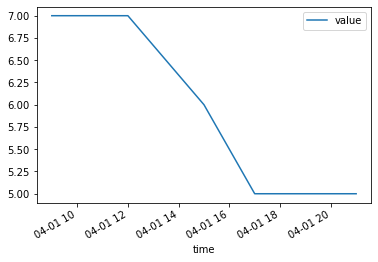

In [614]:
#mood change during day quite large 7 -> 5
df.loc[pd.IndexSlice['AS14.01', '2014-04-01',:]].loc[pd.IndexSlice[:,:,'mood']].droplevel('id').plot()

In [1016]:
pivot = pd.pivot_table(df, values = 'value', index=['id','time'], columns = 'variable').reset_index()

In [1017]:
pivot.drop(pivot[pivot['mood'].isna()].index, inplace=True)
pivot = pivot.fillna(0)
pivot.sort_values(['id','time'])

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,downtime,mood,sms
7,AS14.01,2014-02-26,0.000000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,1.0,-0.250000,0.750000,106640.850,6.250000,2.0
8,AS14.01,2014-02-27,0.000000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.000,0.0,0.000000,0.333333,194400.000,6.333333,0.0
26,AS14.01,2014-03-21,3.083152,3139.218,6280.890,1007.456,49.544,0.0,172.206,239.751,...,915.445,0.000,598.754,0.000,6.0,0.200000,0.200000,849593.547,6.200000,0.0
27,AS14.01,2014-03-22,3.790084,731.429,4962.918,93.324,21.076,0.0,0.000,98.143,...,37.305,0.000,117.621,0.000,3.0,0.600000,0.500000,1129973.941,6.400000,1.0
28,AS14.01,2014-03-23,2.141117,1286.246,5237.319,94.346,43.403,0.0,0.000,72.823,...,0.000,0.000,30.086,30.386,0.0,0.200000,0.800000,883573.136,6.800000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.304902,726.391,2078.403,124.694,0.000,0.0,0.000,142.686,...,0.000,0.000,56.173,0.000,1.0,-0.600000,0.400000,924700.988,6.200000,2.0
1969,AS14.33,2014-05-28,2.479228,2551.046,1936.415,614.706,0.000,0.0,357.909,529.946,...,0.000,0.000,30.666,0.000,10.0,0.000000,1.200000,955861.939,8.200000,1.0
1970,AS14.33,2014-05-29,4.064507,400.034,435.105,136.738,0.000,0.0,0.000,29.202,...,0.939,0.000,3.199,0.000,5.0,-1.333333,1.000000,834315.349,7.000000,1.0
1971,AS14.33,2014-05-30,4.050925,3044.030,1670.842,260.220,0.000,0.0,0.000,52.610,...,1052.648,8.072,232.825,0.000,4.0,-0.800000,-0.400000,1189367.823,6.800000,0.0


In [1018]:
pivot.head(10)

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,downtime,mood,sms
7,AS14.01,2014-02-26,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.0,-0.25,0.750000,106640.850,6.250000,2.0
8,AS14.01,2014-02-27,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.0,0.00,0.333333,194400.000,6.333333,0.0
26,AS14.01,2014-03-21,3.083152,3139.218,6280.890,1007.456,49.544,0.000,172.206,239.751,...,915.445,0.000,598.754,0.000,6.0,0.20,0.200000,849593.547,6.200000,0.0
27,AS14.01,2014-03-22,3.790084,731.429,4962.918,93.324,21.076,0.000,0.000,98.143,...,37.305,0.000,117.621,0.000,3.0,0.60,0.500000,1129973.941,6.400000,1.0
28,AS14.01,2014-03-23,2.141117,1286.246,5237.319,94.346,43.403,0.000,0.000,72.823,...,0.000,0.000,30.086,30.386,0.0,0.20,0.800000,883573.136,6.800000,0.0
29,AS14.01,2014-03-24,1.895065,866.956,9270.629,976.971,34.106,0.000,3.010,66.558,...,419.805,0.000,178.732,0.000,10.0,0.80,0.000000,955291.156,6.000000,0.0
30,AS14.01,2014-03-25,2.360979,1032.768,10276.751,68.206,43.054,0.000,0.000,178.819,...,0.000,235.223,222.893,0.000,0.0,0.50,0.500000,920704.812,6.750000,1.0
31,AS14.01,2014-03-26,2.431400,1167.497,8988.753,910.479,52.331,0.000,0.000,97.498,...,0.000,0.000,33.365,0.000,0.0,-0.20,0.600000,937093.458,6.600000,0.0
32,AS14.01,2014-03-27,3.509234,1229.327,6936.512,639.339,42.219,0.000,182.451,58.532,...,47.314,0.000,179.029,0.000,2.0,0.20,0.800000,1059590.652,7.000000,1.0
33,AS14.01,2014-03-28,2.296753,10062.595,866.833,1005.403,89.166,233.036,0.000,225.951,...,1133.009,0.000,301.717,0.000,5.0,-0.60,0.600000,1162939.221,6.400000,0.0


In [1019]:
for i in range(1,10):
    label = 'mood_prev' + str(i)
    pivot[label] = pivot['mood'].shift(i)
    pivot.loc[pivot['id'].shift(i) != pivot['id'],label] = pd.NA
pivot.head(10)

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,sms,mood_prev1,mood_prev2,mood_prev3,mood_prev4,mood_prev5,mood_prev6,mood_prev7,mood_prev8,mood_prev9
7,AS14.01,2014-02-26,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,2.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,AS14.01,2014-02-27,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,6.25,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
26,AS14.01,2014-03-21,3.083152,3139.218,6280.890,1007.456,49.544,0.000,172.206,239.751,...,0.0,6.333333,6.25,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
27,AS14.01,2014-03-22,3.790084,731.429,4962.918,93.324,21.076,0.000,0.000,98.143,...,1.0,6.2,6.333333,6.25,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
28,AS14.01,2014-03-23,2.141117,1286.246,5237.319,94.346,43.403,0.000,0.000,72.823,...,0.0,6.4,6.2,6.333333,6.25,<NA>,<NA>,<NA>,<NA>,<NA>
29,AS14.01,2014-03-24,1.895065,866.956,9270.629,976.971,34.106,0.000,3.010,66.558,...,0.0,6.8,6.4,6.2,6.333333,6.25,<NA>,<NA>,<NA>,<NA>
30,AS14.01,2014-03-25,2.360979,1032.768,10276.751,68.206,43.054,0.000,0.000,178.819,...,1.0,6.0,6.8,6.4,6.2,6.333333,6.25,<NA>,<NA>,<NA>
31,AS14.01,2014-03-26,2.431400,1167.497,8988.753,910.479,52.331,0.000,0.000,97.498,...,0.0,6.75,6.0,6.8,6.4,6.2,6.333333,6.25,<NA>,<NA>
32,AS14.01,2014-03-27,3.509234,1229.327,6936.512,639.339,42.219,0.000,182.451,58.532,...,1.0,6.6,6.75,6.0,6.8,6.4,6.2,6.333333,6.25,<NA>
33,AS14.01,2014-03-28,2.296753,10062.595,866.833,1005.403,89.166,233.036,0.000,225.951,...,0.0,7.0,6.6,6.75,6.0,6.8,6.4,6.2,6.333333,6.25


In [1020]:
pivot_simple = pivot.copy()
for i in range(2,10):
    label = 'mood_prev' + str(i)
    pivot_simple.drop(label,axis=1,inplace=True)
pivot_simple

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,downtime,mood,sms,mood_prev1
7,AS14.01,2014-02-26,0.000000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,1.0,-0.250000,0.750000,106640.850,6.250000,2.0,<NA>
8,AS14.01,2014-02-27,0.000000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.000,0.000,0.000,0.0,0.000000,0.333333,194400.000,6.333333,0.0,6.25
26,AS14.01,2014-03-21,3.083152,3139.218,6280.890,1007.456,49.544,0.0,172.206,239.751,...,0.000,598.754,0.000,6.0,0.200000,0.200000,849593.547,6.200000,0.0,6.333333
27,AS14.01,2014-03-22,3.790084,731.429,4962.918,93.324,21.076,0.0,0.000,98.143,...,0.000,117.621,0.000,3.0,0.600000,0.500000,1129973.941,6.400000,1.0,6.2
28,AS14.01,2014-03-23,2.141117,1286.246,5237.319,94.346,43.403,0.0,0.000,72.823,...,0.000,30.086,30.386,0.0,0.200000,0.800000,883573.136,6.800000,0.0,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,0.304902,726.391,2078.403,124.694,0.000,0.0,0.000,142.686,...,0.000,56.173,0.000,1.0,-0.600000,0.400000,924700.988,6.200000,2.0,5.4
1969,AS14.33,2014-05-28,2.479228,2551.046,1936.415,614.706,0.000,0.0,357.909,529.946,...,0.000,30.666,0.000,10.0,0.000000,1.200000,955861.939,8.200000,1.0,6.2
1970,AS14.33,2014-05-29,4.064507,400.034,435.105,136.738,0.000,0.0,0.000,29.202,...,0.000,3.199,0.000,5.0,-1.333333,1.000000,834315.349,7.000000,1.0,8.2
1971,AS14.33,2014-05-30,4.050925,3044.030,1670.842,260.220,0.000,0.0,0.000,52.610,...,8.072,232.825,0.000,4.0,-0.800000,-0.400000,1189367.823,6.800000,0.0,7.0


In [1021]:
pivot_simple['screentime'] = pivot_simple[cont].loc[:, pivot_simple[cont].columns!='downtime'].sum(axis=1)

In [1022]:
d = cont[:]
d.remove('downtime')
pivot_simple.drop(d,axis=1,inplace=True)
pivot_simple.drop('circumplex.arousal',axis=1,inplace=True)
pivot_simple.drop('circumplex.valence',axis=1,inplace=True)

In [1023]:
pivot_simple.dropna(axis=0,inplace=True)

In [1024]:
pivot_simple.head(10)

variable,id,time,activity,call,downtime,mood,sms,mood_prev1,screentime
8,AS14.01,2014-02-27,0.000000,0.0,194400.000,6.333333,0.0,6.25,0.000
26,AS14.01,2014-03-21,3.083152,6.0,849593.547,6.200000,0.0,6.333333,16911.764
27,AS14.01,2014-03-22,3.790084,3.0,1129973.941,6.400000,1.0,6.2,6501.448
28,AS14.01,2014-03-23,2.141117,0.0,883573.136,6.800000,0.0,6.4,7695.448
29,AS14.01,2014-03-24,1.895065,10.0,955291.156,6.000000,0.0,6.8,15040.393
30,AS14.01,2014-03-25,2.360979,0.0,920704.812,6.750000,1.0,6.0,13977.185
31,AS14.01,2014-03-26,2.431400,0.0,937093.458,6.600000,0.0,6.75,15841.982
32,AS14.01,2014-03-27,3.509234,2.0,1059590.652,7.000000,1.0,6.6,10250.104
33,AS14.01,2014-03-28,2.296753,5.0,1162939.221,6.400000,0.0,7.0,14430.451
34,AS14.01,2014-03-29,1.636867,4.0,1009422.121,8.000000,1.0,6.4,7596.305


In [1025]:
#remove days if no data for the next day (except last day for the series)
fil = pivot_simple.loc[pivot_simple['time'].shift(-1)-pd.Timedelta(1, 'd') != pivot_simple['time']] #no data for next day
fil = fil.loc[fil['id'].shift(1) != fil['id']] #don't include last day for a series
pivot_simple.drop(fil.index, inplace=True)

In [1026]:
pivot_simple.head(10)

variable,id,time,activity,call,downtime,mood,sms,mood_prev1,screentime
26,AS14.01,2014-03-21,3.083152,6.0,849593.547,6.20,0.0,6.333333,16911.764
27,AS14.01,2014-03-22,3.790084,3.0,1129973.941,6.40,1.0,6.2,6501.448
28,AS14.01,2014-03-23,2.141117,0.0,883573.136,6.80,0.0,6.4,7695.448
29,AS14.01,2014-03-24,1.895065,10.0,955291.156,6.00,0.0,6.8,15040.393
30,AS14.01,2014-03-25,2.360979,0.0,920704.812,6.75,1.0,6.0,13977.185
31,AS14.01,2014-03-26,2.431400,0.0,937093.458,6.60,0.0,6.75,15841.982
32,AS14.01,2014-03-27,3.509234,2.0,1059590.652,7.00,1.0,6.6,10250.104
33,AS14.01,2014-03-28,2.296753,5.0,1162939.221,6.40,0.0,7.0,14430.451
34,AS14.01,2014-03-29,1.636867,4.0,1009422.121,8.00,1.0,6.4,7596.305
35,AS14.01,2014-03-30,0.687302,0.0,938302.480,7.50,0.0,8.0,3595.008


In [1070]:
columns = list(pivot_simple.columns)
columns.remove('id')
columns.remove('time')
ids = list(pivot_simple['id'].unique())
pivot_simple = pivot_simple.set_index(['id', 'time'])

ValueError: list.remove(x): x not in list

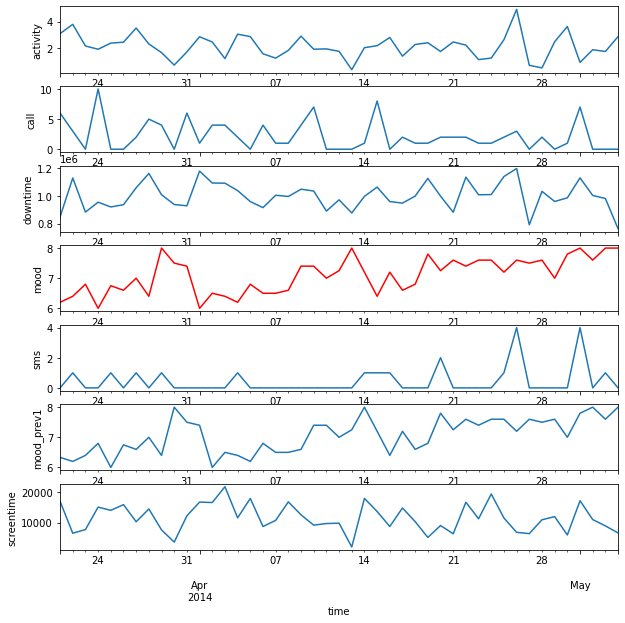

In [1031]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

fig, axes = plt.subplots(len(columns))
for i,col in enumerate(columns):
    if col == 'mood':
        pivot_simple.loc['AS14.01',col].plot(ax=axes[i],ylabel=col,c='r')
    else:
        pivot_simple.loc['AS14.01',col].plot(ax=axes[i],ylabel=col)

In [1069]:
correlation = {}
for idx in ids:
    for i,col in enumerate(columns):
        if col != 'mood' and col:
            if col in correlation:
                correlation[col] += abs(pivot_simple.loc[idx,'mood'].astype(float).corr(pivot_simple.loc[idx,col].astype(float)))/len(ids)
            else:
                correlation[col] = abs(pivot_simple.loc[idx,'mood'].astype(float).corr(pivot_simple.loc[idx,col].astype(float)))/len(ids)
correlation
plt.bar(*zip(*correlation.items()))

KeyError: 'appCat.builtin'

In [1063]:
columns = list(pivot.columns)
columns.remove('id')
columns.remove('time')
ids = list(pivot['id'].unique())
correlation = {}
pivot2 = pivot.set_index(['id', 'time'])
for idx in ids:
    for i,col in enumerate(columns):
        if 'mood' not in col:
            if col in correlation:
                correlation[col] += abs(pivot2.loc[idx,'mood'].astype(float).corr(pivot2.loc[idx,col].astype(float)))/len(ids)
            else:
                correlation[col] = abs(pivot2.loc[idx,'mood'].astype(float).corr(pivot2.loc[idx,col].astype(float)))/len(ids)
correlation

{'activity': 0.186568091962208,
 'appCat.builtin': 0.1387727959024681,
 'appCat.communication': 0.15172116160826765,
 'appCat.entertainment': 0.12572018022446502,
 'appCat.finance': nan,
 'appCat.game': nan,
 'appCat.office': nan,
 'appCat.other': 0.13068994937191275,
 'appCat.social': 0.14685447099499752,
 'appCat.travel': 0.11760426232369006,
 'appCat.unknown': nan,
 'appCat.utilities': nan,
 'appCat.weather': nan,
 'call': 0.17416984463590915,
 'circumplex.arousal': 0.26702022310765056,
 'circumplex.valence': 0.7318464833654007,
 'downtime': 0.1528826282104937,
 'sms': 0.09619059060772005}

<BarContainer object of 18 artists>

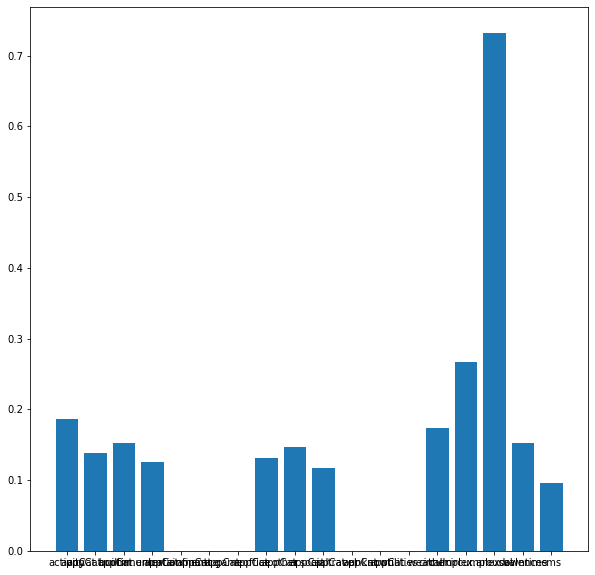

In [1068]:
plt.bar(*zip(*correlation.items()))

In [1071]:
columns

['activity', 'call', 'downtime', 'mood', 'sms', 'mood_prev1', 'screentime']